# Agents and Agentic workflows

In simple terms, take a task--> divide into subtasks-->each subtask is performed by an agent or group of agents---> repeat until done

so, Planning-->Tools--->Reflection(iteratively improving results by several means)

In addition we need memory which will assist in tracking this process and results evalutaion

In the following image you can see that **these agents and their behaviour forms a cycilical graph**


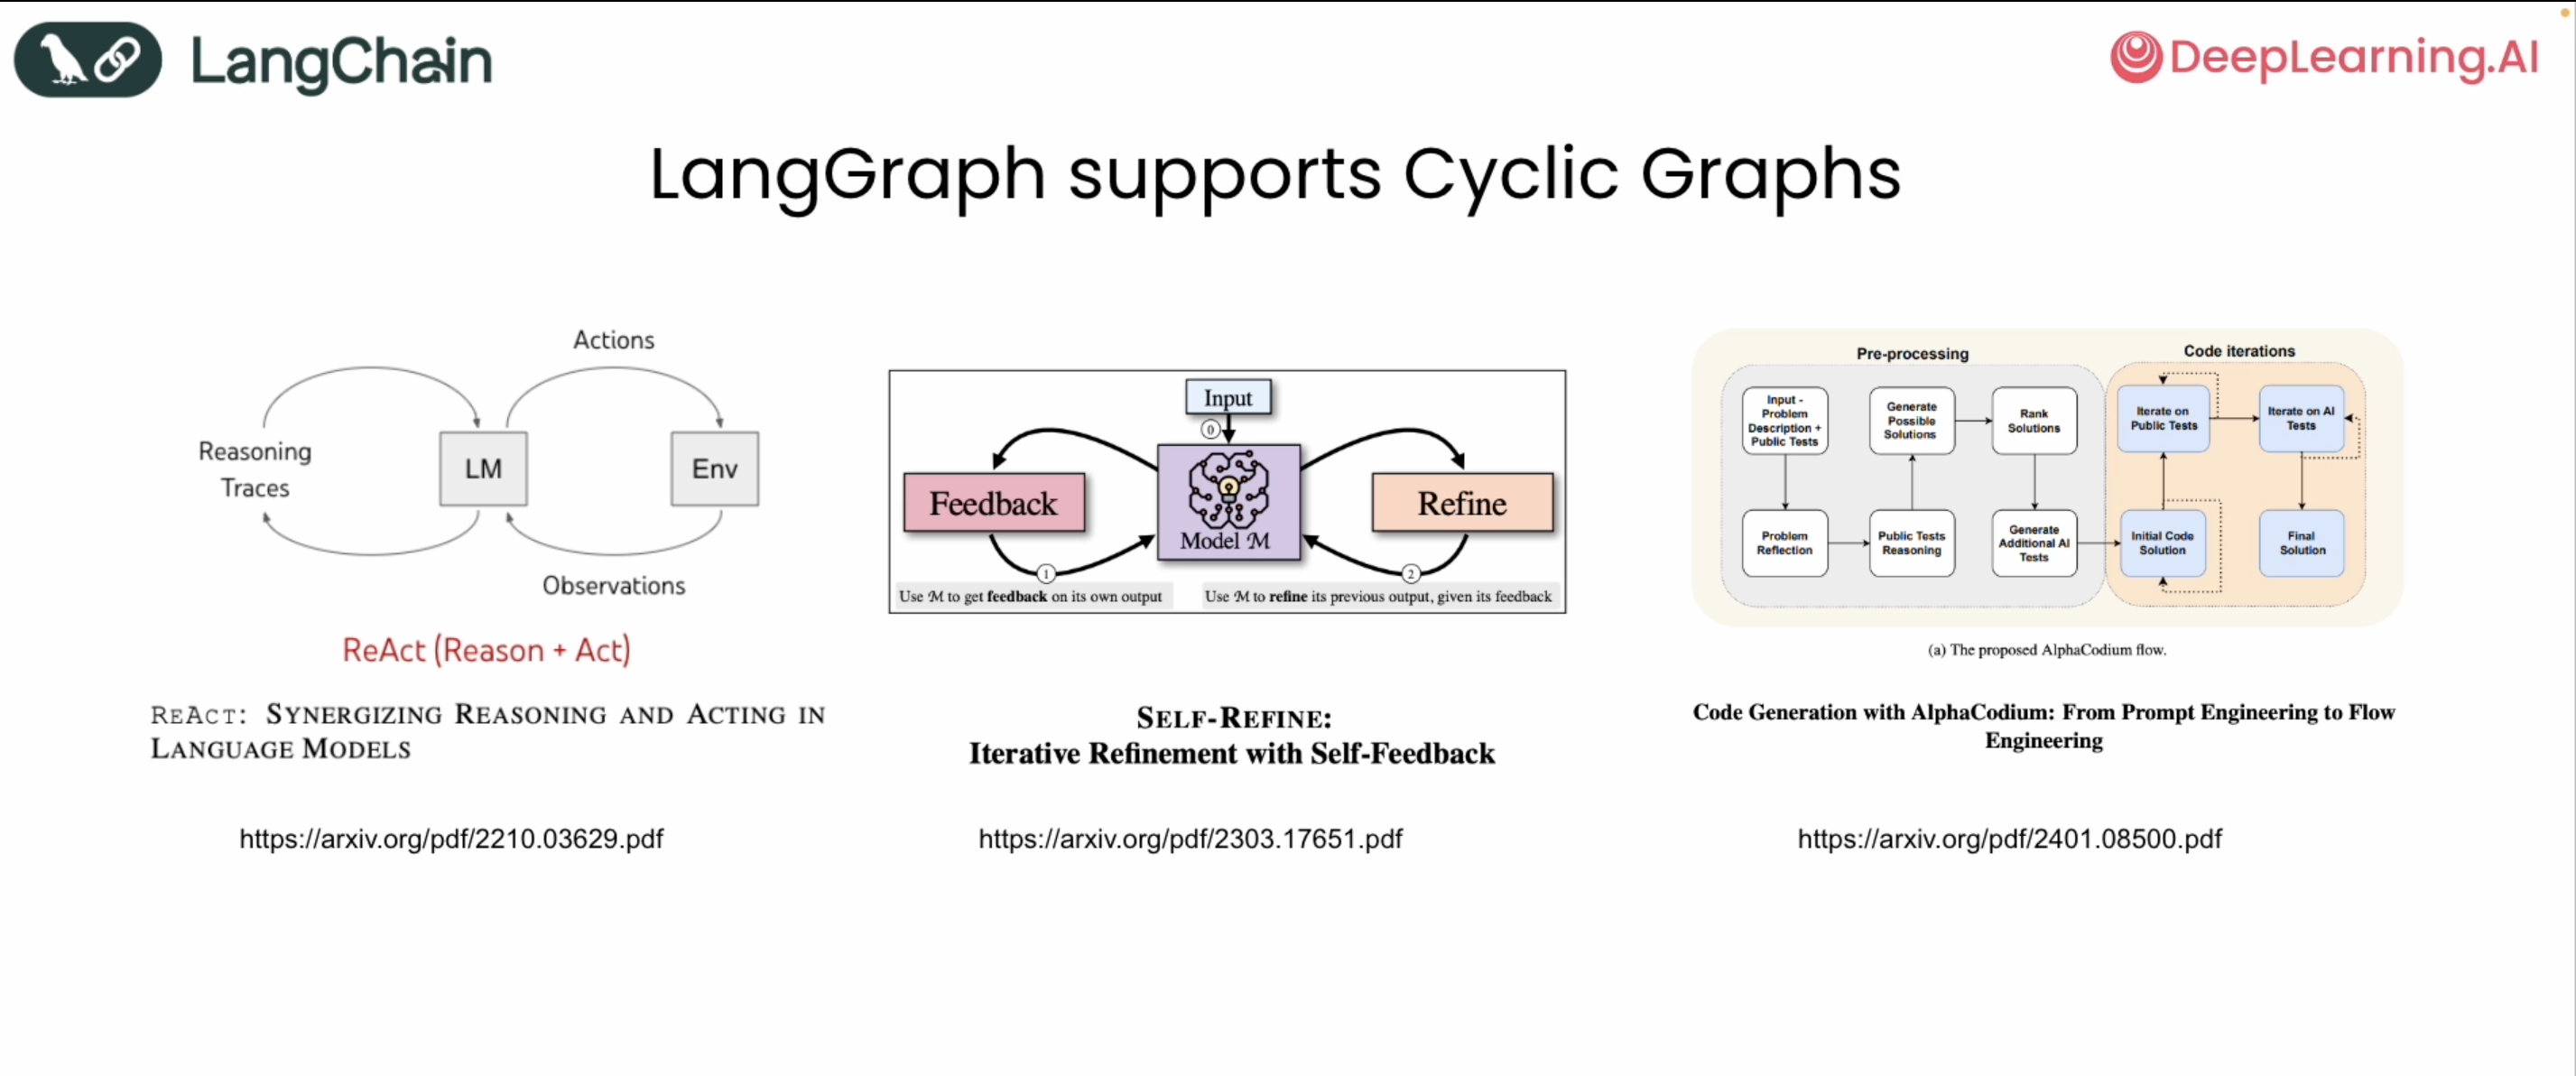

AI Agents in LangGraph

A very basic ReAct(reasoning + acting) agent where I will see what jobs falls to LLM and what jobs are managed by code around the LLM(runtime)

ReAct: First think what todo and then take action and return obseervation

In [ ]:
!pip install openai
!pip install httpx
!pip install langchain
!pip install langgraph
!pip install langchain_openai
!pip install langchain-community
!pip install duckduckgo-search
!pip install langchain_community


#needed for IMage display for the Graph Created
!apt-get install graphviz graphviz-dev
!pip install pygraphviz

In [72]:
import openai
import re
import httpx
import os
from openai import OpenAI

#openai client
client=OpenAI(
    api_key="OpenAIKEY"
)


In [73]:
class Agent:
  def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

  # take a messgae that is comming and append to the exiting array of messages.
  def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

  # execution of the input messgae via LLM
  def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o",
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content


In [74]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [75]:
#Simple tools

def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier":
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

#more specific to the problem we are solving
known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [76]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action, arround llm, it will stop when final task is completed even if the max_turn are remaining.
def query(question, max_turns=9):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1

        result = bot(next_prompt)
        print(f'\n i={i}, res= {result}\n')
        actions = [
            action_re.match(a)
            for a in result.split('\n')
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input) # from the known action get the action and pass the input to the action tool
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation) # create next observation prompt for subsequent call
        else:
            return

In [77]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)


 i=1, res= Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to find the combined weight.
Action: average_dog_weight: Border Collie
PAUSE

 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs

 i=2, res= Action: average_dog_weight: Scottish Terrier
PAUSE

 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs

 i=3, res= Action: calculate: 37 + 20
PAUSE

 -- running calculate 37 + 20
Observation: 57

 i=4, res= Answer: The combined average weight of a Border Collie and a Scottish Terrier is 57 lbs.



The above code workflow is as follows:
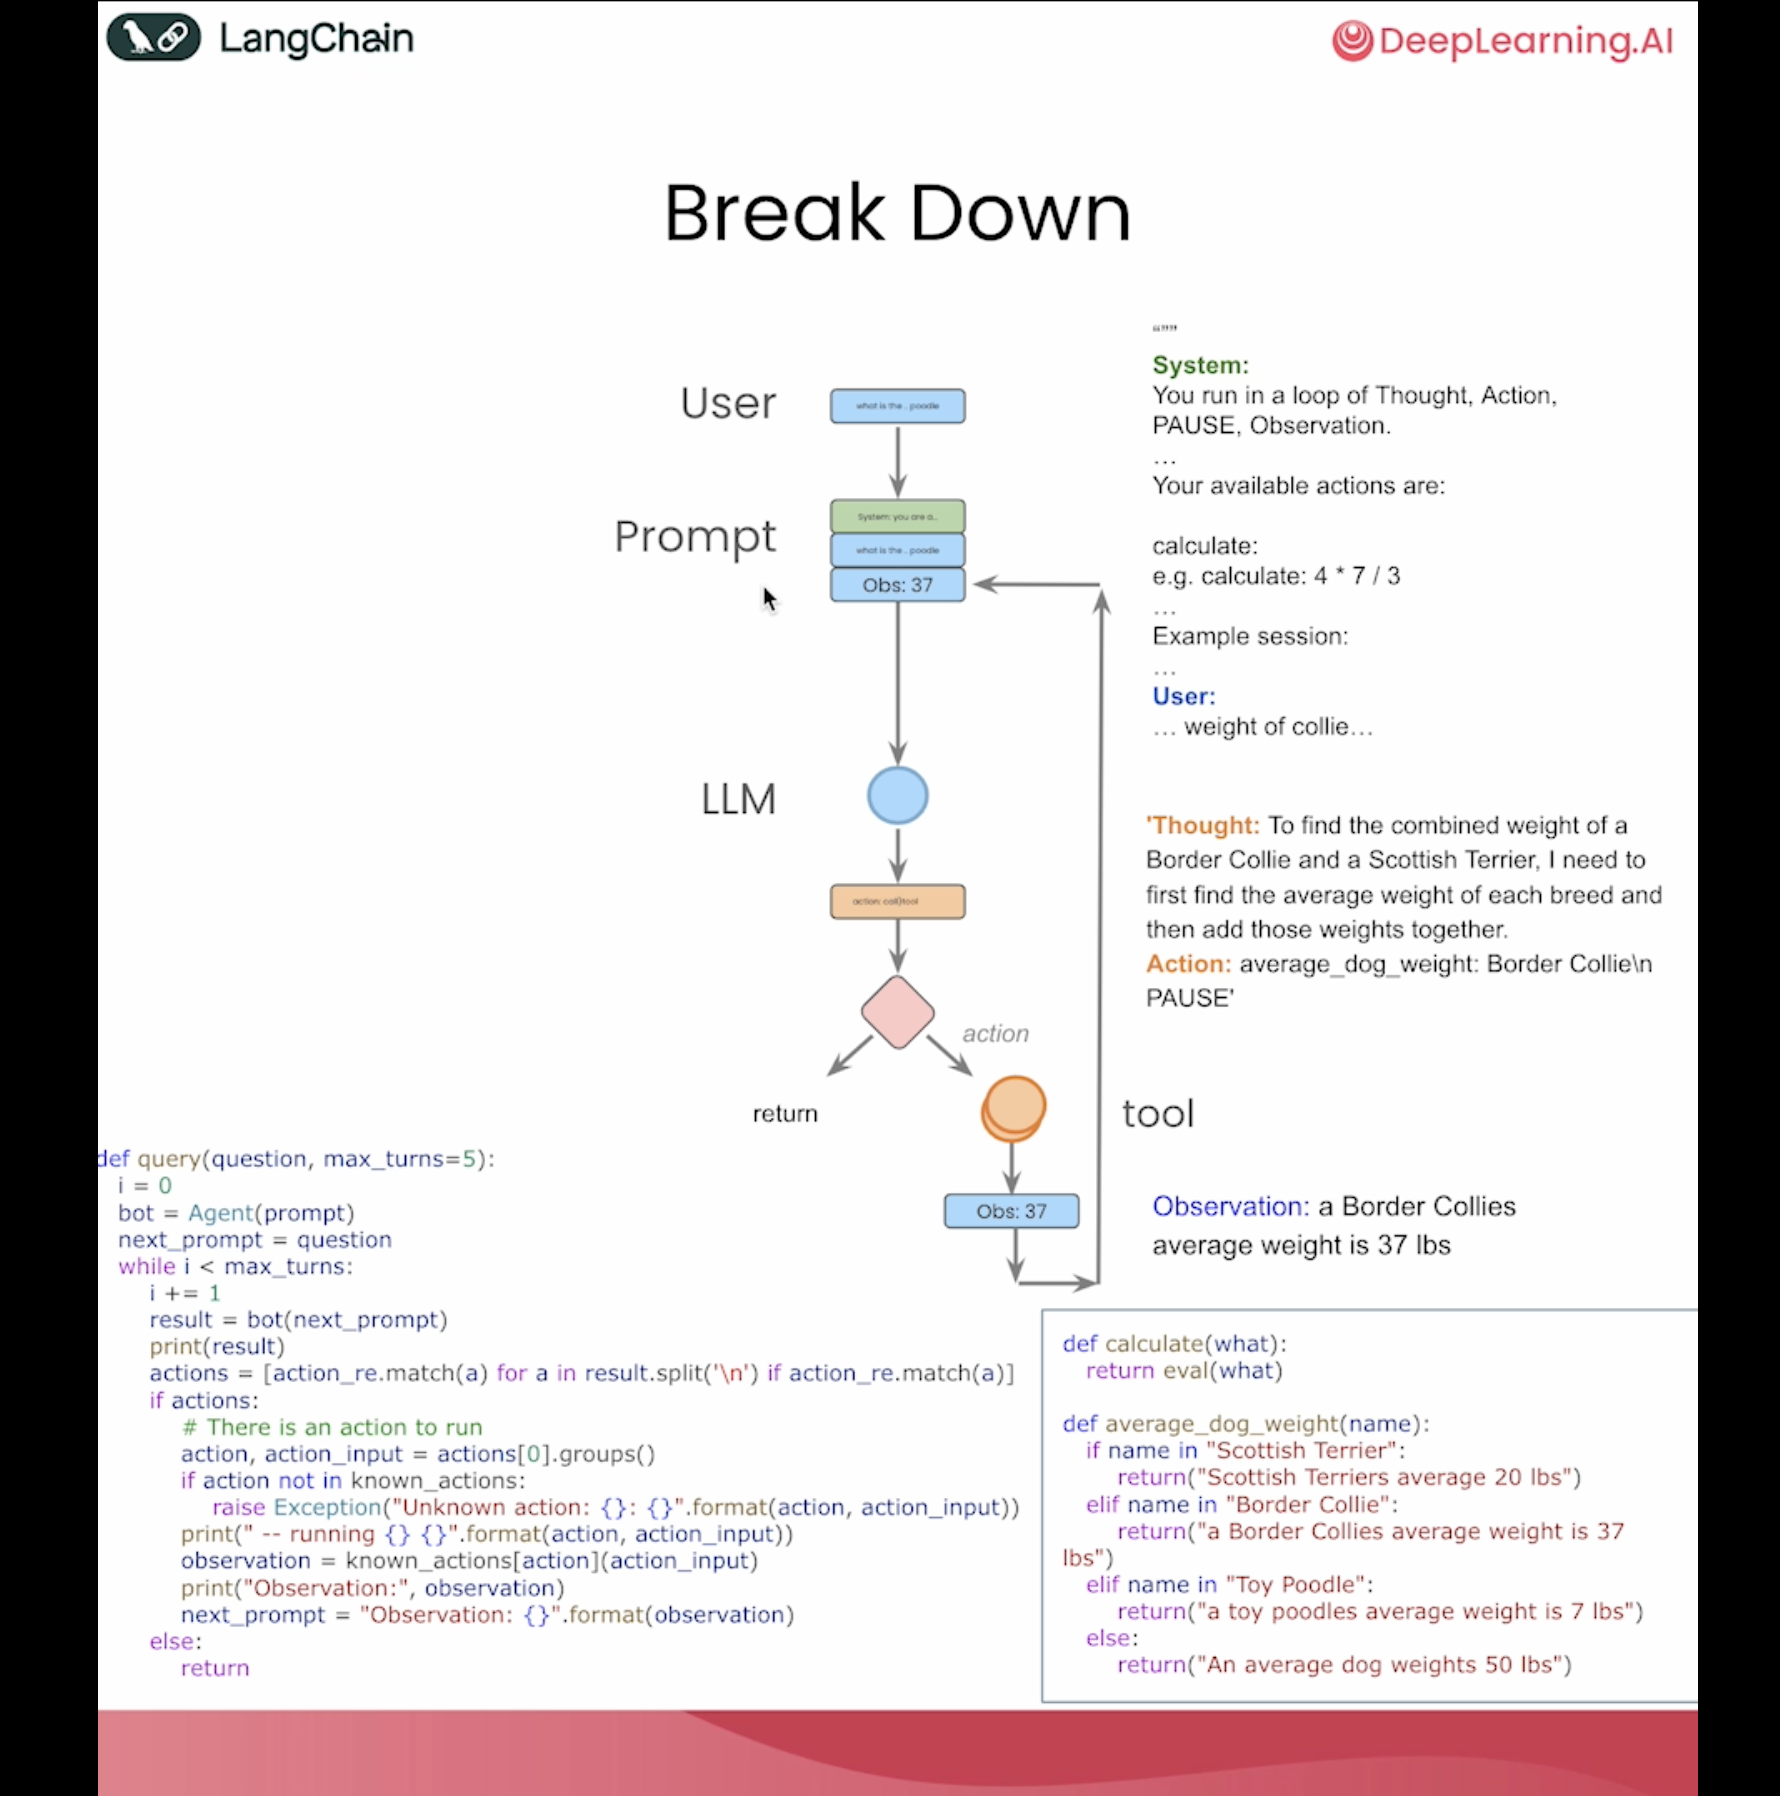

# Agent using LangGraph




## LangGraphComponent

LangGraph help you descibe anbd orcehestrate the control flow, i,e, allow you to create cyclic graph which is excatly we see in previous image.
COmes with built in persistence - also consit of human in the loop features



```
Node : Agents or function
Edgess : connect these nodes
Conditional edges: used when I  want to make decisions about which node I shoudld go next

```


Agent State:

  - Local to the graph
  - Accessible to all parts of the graph
  - Can be stored in persistence layer, i.e. I can resume at point in time

In [85]:
!pip install duckduckgo-search


In [88]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain.utilities import DuckDuckGoSearchAPIWrapper
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain.agents import AgentType

In [91]:
os.environ["TAVILY_API_KEY"] = "" # api key
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)


<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [92]:

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add] # takes new messages and using add operater message is appended.

In [93]:
'''
Initialize graph
Add nodes to graph
Add conditonal nodes to graph

Add conditional edge to graph
Add next edge depending on the logic and implementation

Add an entry point to graph(node name)
COmpile the graph

'''

class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system

        #create grpah
        graph = StateGraph(AgentState)

        #add nodes
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)

        #completion edge to check if action node present or not
        graph.add_conditional_edges(
            "llm", # node from where edge start
            self.exists_action, # determine function where to go next
            {True: "action", False: END} #how to map the resepone to the function and next node to go to, If true goto next node else end node
        )

        # next node go back to llm
        graph.add_edge("action", "llm")

        # entry point for graph
        graph.set_entry_point("llm")

        # compile graph, will turn into langchain runnable(standrd interface for calling and invoking the grpah)
        self.graph = graph.compile()

        # tools
        self.tools = {t.name: t for t in tools}

        # letting the model know that I have these tools
        self.model = model.bind_tools(tools)


    # check whether action present or not
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    # call llm, llm node
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]} # only one message returned from the model

    # perform action, action node
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [110]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key="OPENAIKEY")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

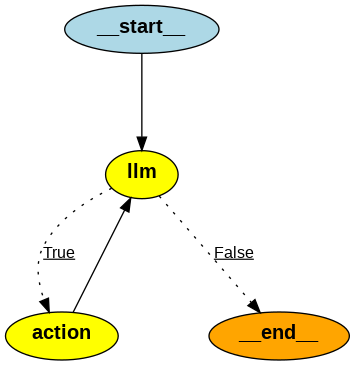

In [102]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [103]:
messages = [HumanMessage(content="What is the date when transformer model is released?")]
result = abot.graph.invoke({"messages": messages})
#simpel query

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Transformer model release date'}, 'id': 'call_D0iqvOcAORQQJV0LF5eXWymO', 'type': 'tool_call'}
Back to the model!


In [104]:
result

{'messages': [HumanMessage(content='What is the date when transformer model is released?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_D0iqvOcAORQQJV0LF5eXWymO', 'function': {'arguments': '{"query":"Transformer model release date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 156, 'total_tokens': 177, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0ad70a59-02cb-4110-a792-092058c52c54-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Transformer model release date'}, 'id': 'call_D0iqvOcAORQQJV0LF5eXWymO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 

In [108]:
result['messages'][-1]

AIMessage(content='The Transformer model was first presented in the ground-breaking paper "Attention is All You Need" in 2017.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 2098, 'total_tokens': 2122, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-291e9a4e-e041-4f19-a88a-33f10281892a-0', usage_metadata={'input_tokens': 2098, 'output_tokens': 24, 'total_tokens': 2122, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [112]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})
#withput going back to model it called another search, example of parallel function

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ad17RJj29vu5finOPl1zAJae', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Of2akIJ8sOw1ij0fNoR0yXSa', 'type': 'tool_call'}
Back to the model!


In [113]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]


abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

# output will be sequential calling of tool

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_Sdy8IgruWXNBiR6TVCGa3vjX', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': "State where Super Bowl 2024 winner's headquarters located"}, 'id': 'call_KbOKzt8tCwnnemCR02tgWmf3', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP'}, 'id': 'call_j1YStWGB8kL2VagCzItKVo0O', 'type': 'tool_call'}
Back to the model!


# Persistence and Streaming

- Persistence lets you keep around the state of an agent at a particular point in time, this can let you go back to that state and resume to that state.
 - Persistance allow human in loop feedback too. It depends on your usecase and implementation

- Streamring: you can omit signal for that particular moment


In [1]:
# we initilize a checkpointer to do persistence: here i am using sqlite and attach it to graph.commplie as done above


from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")


'''
   def __init__(self, model, tools, system=""):
        self.system = system

        #create grpah
        graph = StateGraph(AgentState)

        #add nodes
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)

        #completion edge to check if action node present or not
        graph.add_conditional_edges(
            "llm", # node from where edge start
            self.exists_action, # determine function where to go next
            {True: "action", False: END} #how to map the resepone to the function and next node to go to, If true goto next node else end node
        )

        # next node go back to llm
        graph.add_edge("action", "llm")

        # entry point for graph
        graph.set_entry_point("llm")

        # compile graph, will turn into langchain runnable(standrd interface for calling and invoking the grpah)
        self.graph = graph.compile(checkpointer=checkpointer)

        # tools
        self.tools = {t.name: t for t in tools}

        # letting the model know that I have these tools
        self.model = model.bind_tools(tools)

'''

# and now create out agent as follows
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)


In [ ]:
'''
for streaming using `stream` method

abot.graph.stream()
'''


'''
for streaming tokens themselves like chatgpt

use `astream` method

in langchain we can use = abot.graph.astream_events
also, use async for memmory: memory = AsyncSqliteSaver.from_conn_string(":memory:")

these type of streaming is realtime streaming into the screen
'''

# sample code:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

messages = [HumanMessage(content="What is the weather in SF?")]
thread = {"configurable": {"thread_id": "4"}}
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")